In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import os

RESULTS_PATH = 'results/eval_results_777.csv'
sns.set_style("whitegrid")

In [52]:
# Load Data
df = pd.read_csv(RESULTS_PATH)

# Filter (Uncomment to select specific runs/seeds)
# df = df[df['random_seed'] == 42]

# Extract dimensions
def extract_dims(s):
    m = re.search(r'pca(\d+)', s)
    return int(m.group(1)) if m else 512

df['dims'] = df['similarity_space'].apply(extract_dims)

# Aggregate metrics by dimension (averaging across seeds if multiple exist)
df_agg = df.groupby('dims', as_index=False)[['mean_latency', 'recall_mean', 'qps']].mean()
df_agg = df_agg.sort_values('dims')

FileNotFoundError: [Errno 2] No such file or directory: 'results/eval_results_777.csv'

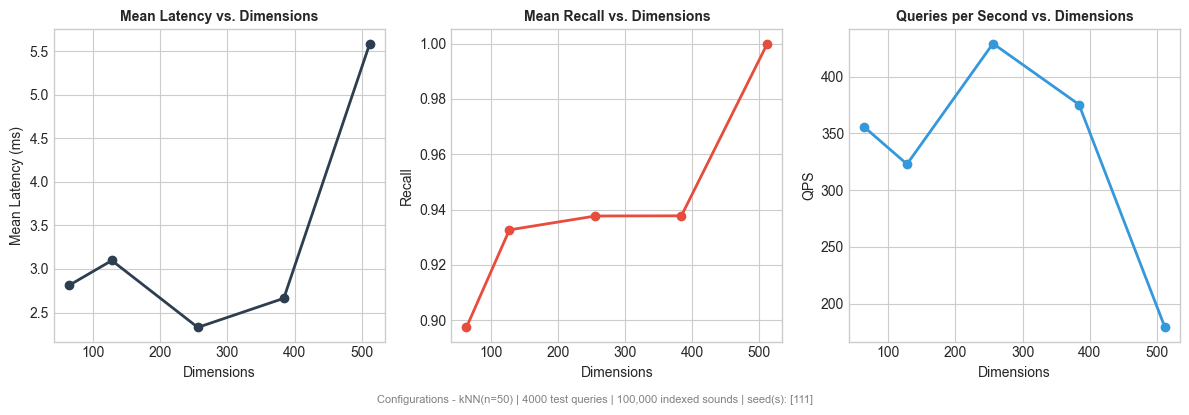

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Mean Latency vs. Dimensions
ax1.plot(df_agg['dims'], df_agg['mean_latency'], marker='o', color='#2c3e50', linewidth=2)
ax1.set_title('Mean Latency vs. Dimensions', fontweight='bold', fontsize=10)
ax1.set_xlabel('Dimensions')
ax1.set_ylabel('Mean Latency (ms)')

# Mean Recall vs. Dimensions
ax2.plot(df_agg['dims'], df_agg['recall_mean'], marker='o', color='#e74c3c', linewidth=2)
ax2.set_title('Mean Recall vs. Dimensions', fontweight='bold', fontsize=10)
ax2.set_xlabel('Dimensions')
ax2.set_ylabel('Recall')

# QPS vs. Dimensions
ax3.plot(df_agg['dims'], df_agg['qps'], marker='o', color='#3498db', linewidth=2)
ax3.set_title('Queries per Second vs. Dimensions', fontweight='bold', fontsize=10)
ax3.set_xlabel('Dimensions')
ax3.set_ylabel('QPS')

# Footer with config info
latest = df.iloc[-1]
info = f"Configurations - kNN(n={int(latest['n_neighbors'])}) | {int(latest['query_size'])} test queries | {int(latest['index_num_sounds']):,} indexed sounds | seed(s): {df['random_seed'].unique()}"
fig.text(0.5, -0.02, info, ha='center', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

/var/folders/3v/0hwn75710098_hd46qf_1b_h0000gn/T/ipykernel_13600/2965140362.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_details = pd.concat(all_details, ignore_index=True)


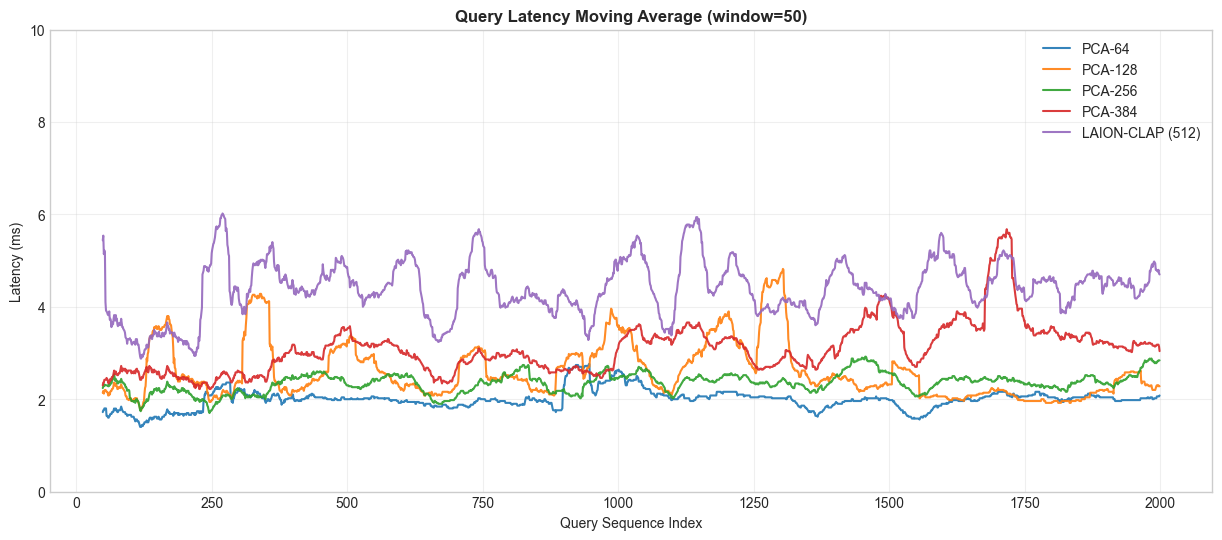


--- Latency Analysis (Warmup vs Steady State) ---
           Space  All Mean (ms)  Steady State Mean (ms)  Steady Std (ms)  Warmup Penalty (%)
          PCA-64          1.994                   2.026            0.835                -1.6
         PCA-128          2.584                   2.560            1.731                 0.9
         PCA-256          2.350                   2.398            0.785                -2.0
         PCA-384          3.076                   3.210            1.686                -4.2
LAION-CLAP (512)          4.424                   4.449            2.216                -0.5


In [51]:
# Analysis of per-query latency
seed = 777
detail_files = glob.glob(f"results/per_query/{seed}/per_query_results_*.pkl")
all_details = []

if not detail_files:
    print("No detail pickle files found in results/per_query/")
else:
    for f in detail_files:
        try:
            if "pca" in f:
                m = re.search(r'pca(\d+)', f)
                dim = m.group(1) if m else "Tx"
                label = f"PCA-{dim}"
            else:
                label = "LAION-CLAP (512)"
            
            df_det = pd.read_pickle(f)
            df_det['label'] = label
            all_details.append(df_det)
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if all_details:
        df_details = pd.concat(all_details, ignore_index=True)
        
        plt.figure(figsize=(15, 6))
        plt.ylim(0, 10)
        
        # Sort labels to be consistent
        labels = sorted(df_details['label'].unique(), key=lambda x: int(x.split('-')[1]) if '-' in x and 'LAION' not in x else 999)
        
        for label in labels:
            subset = df_details[df_details['label'] == label].sort_values('query_index')
            # Rolling mean to smooth variance and see the trend
            plt.plot(subset['query_index'], subset['latency_ms'].rolling(window=50).mean(), label=label, linewidth=1.5, alpha=0.9)
            
        plt.title('Query Latency Moving Average (window=50)', fontsize=12, fontweight='bold')
        plt.xlabel('Query Sequence Index')
        plt.ylabel('Latency (ms)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Calculate Steady State Statistics (Excluding first 500 queries)
        print("\n--- Latency Analysis (Warmup vs Steady State) ---")
        stats = []
        for label in labels:
            subset = df_details[df_details['label'] == label]
            mean_all = subset['latency_ms'].mean()
            # Steady state: after query 500
            mean_steady = subset[subset['query_index'] > 500]['latency_ms'].mean()
            std_steady = subset[subset['query_index'] > 500]['latency_ms'].std()
            
            stats.append({
                'Space': label,
                'All Mean (ms)': round(mean_all, 3),
                'Steady State Mean (ms)': round(mean_steady, 3),
                'Steady Std (ms)': round(std_steady, 3),
                'Warmup Penalty (%)': round(((mean_all - mean_steady) / mean_steady) * 100, 1)
            })
            
        df_stats = pd.DataFrame(stats)
        print(df_stats.to_string(index=False))
    else:
        print("No valid data loaded.")